In [13]:
#loading Libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
#Function for creating a single csv
def single_csv(pr,ghi):
    pr_df=[]
    ghi_df=[]
    
    #Reading PR files and appending it into pr dataframe
    
    for root,dir,files in os.walk(pr):
        for file in files:
            file_path=os.path.join(root,file)
            #print(file_path)
            df=pd.read_csv(file_path)
            #print(df)
            pr_df.append(df)

     #Reading GHI files and appending it into pr 
    
    for root,dir,files in os.walk(ghi):
        for file in files:
            file_path=os.path.join(root,file)
            #print(file_path)
            df=pd.read_csv(file_path)
            #print(df)
            ghi_df.append(df)
           

    # Combining Data of both files
    
    combined_pr=pd.concat(pr_df,ignore_index=True)
    #print(combined_pr)
    combined_ghi=pd.concat(ghi_df,ignore_index=True)
    #print(combined_ghi)

    #Merging both data
    
    single_df=pd.merge(combined_pr,combined_ghi,on='Date',how='outer')
    single_df=single_df.sort_values(by='Date')
    #print(single_df)

    #Exporting it in a csv
    single_df.to_csv('Single_csv.csv', index=False)
    
    return True
    
    

In [6]:
pr_path = r'data\PR'
ghi_path = r'data\GHI'

combined_df = single_csv(pr_path, ghi_path)

In [7]:
#Analysing the File
df= pd.read_csv('single_csv.csv')
df.shape

(982, 3)

In [9]:
df.sample(5)

,Date,PR,GHI
169,2019-12-17,77.943467,4.757833
117,2019-10-26,63.869731,5.485858
756,2021-08-11,82.351688,4.361525
918,2022-01-20,64.040773,5.157525
138,2019-11-16,82.331744,3.784533


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    982 non-null    object 
 1   PR      982 non-null    float64
 2   GHI     982 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.1+ KB


In [81]:
df.describe()

,PR,GHI
count,982.000000,982.000000
mean,72.714933,4.629912
std,7.294222,1.024159
min,60.023886,1.413825
25%,66.309422,4.021665
50%,72.947945,4.737796
75%,79.111721,5.312283
max,84.980120,6.947317


In [82]:
df.duplicated().sum()

0

In [87]:
df.dtypes

Date     object
PR      float64
GHI     float64
dtype: object

In [72]:
def plot(df, start_date=None, end_date=None):
    df['Date'] = pd.to_datetime(df['Date'])
    if start_date:
        df = df[df['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df['Date'] <= pd.to_datetime(end_date)]

    df = df.sort_values('Date').reset_index(drop=True)
    #print(df)
    
    #GHI
    def ghi_color(ghi):
        if ghi < 2:
            return 'navy'
        elif ghi < 4:
            return 'skyblue'
        elif ghi < 6:
            return 'orange'
        else:
            return 'brown'
        
    df['Color'] = df['GHI'].apply(ghi_color)
    
    #print(df)
    #30-day moving average
    df['PR_30d_avg'] = df['PR'].rolling(window=30, min_periods=1).mean()

    # Budget PR calculation based on dynamic years
    def budget(date):
        base = 73.9
        years = (date.year - 2019) + (date.month - 7) / 12  
        return base - (0.8 * years)

    df['Budget_PR'] = df['Date'].apply(budget)

    # Calculate points above budget PR
    points_above_budget = (df['PR'] > df['Budget_PR']).sum()
    total_points = len(df)

    # Plotting
    plt.figure(figsize=(16, 8))
      #Ploting Points of ghi        
    for ghi_range, color in [('navy', '<2'), ('skyblue', '2-4'), ('orange', '4-6'), ('brown', '>6')]:
        subset = df[df['Color'] == ghi_range]
        plt.scatter(subset['Date'], subset['PR'], label=f'GHI {color}', color=ghi_range, s=10)

    # Plot 30-day moving average
    plt.plot(df['Date'], df['PR_30d_avg'], color='red', linewidth=2, label='30-d moving average of PR')

    # Plot Budget PR Line (Dynamic)
    plt.plot(df['Date'], df['Budget_PR'], color='green', linewidth=2, label='Target Budget Yield PR')

    # Text Box - Stats
    avg_7d = df['PR'].tail(7).mean()
    avg_30d = df['PR'].tail(30).mean()
    avg_60d = df['PR'].tail(60).mean()
    avg_90d = df['PR'].tail(90).mean()
    avg_365d = df['PR'].tail(365).mean()
    avg_lifetime = df['PR'].mean()

    stats_text = (
        f"Average PR last 7-d: {avg_7d:.1f} %\n"
        f"Average PR last 30-d: {avg_30d:.1f} %\n"
        f"Average PR last 60-d: {avg_60d:.1f} %\n"
        f"Average PR last 90-d: {avg_90d:.1f} %\n"
        f"Average PR last 365-d: {avg_365d:.1f} %\n"
        f"Average PR Lifetime: {avg_lifetime:.1f} %"
    )
    plt.text(df['Date'].iloc[-1], 10, stats_text, ha='right', va='bottom', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='gray'))

    percent_above = 100 * points_above_budget / total_points
    plt.title(f"Performance Ratio [%] from {df['Date'].min().date()} to {df['Date'].max().date()}")
    plt.xlabel("Date")
    plt.ylabel("Performance Ratio [%]")
    plt.axhline(0, color='black', linewidth=0.1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.text(df['Date'].iloc[len(df)//3], 45, f"Points above Target Budget PR = {points_above_budget}/{total_points} = {percent_above:.2f}%", fontsize=11)

    plt.tight_layout()
    plt.savefig('pr_graph.png', dpi=300, bbox_inches='tight')
    plt.show()



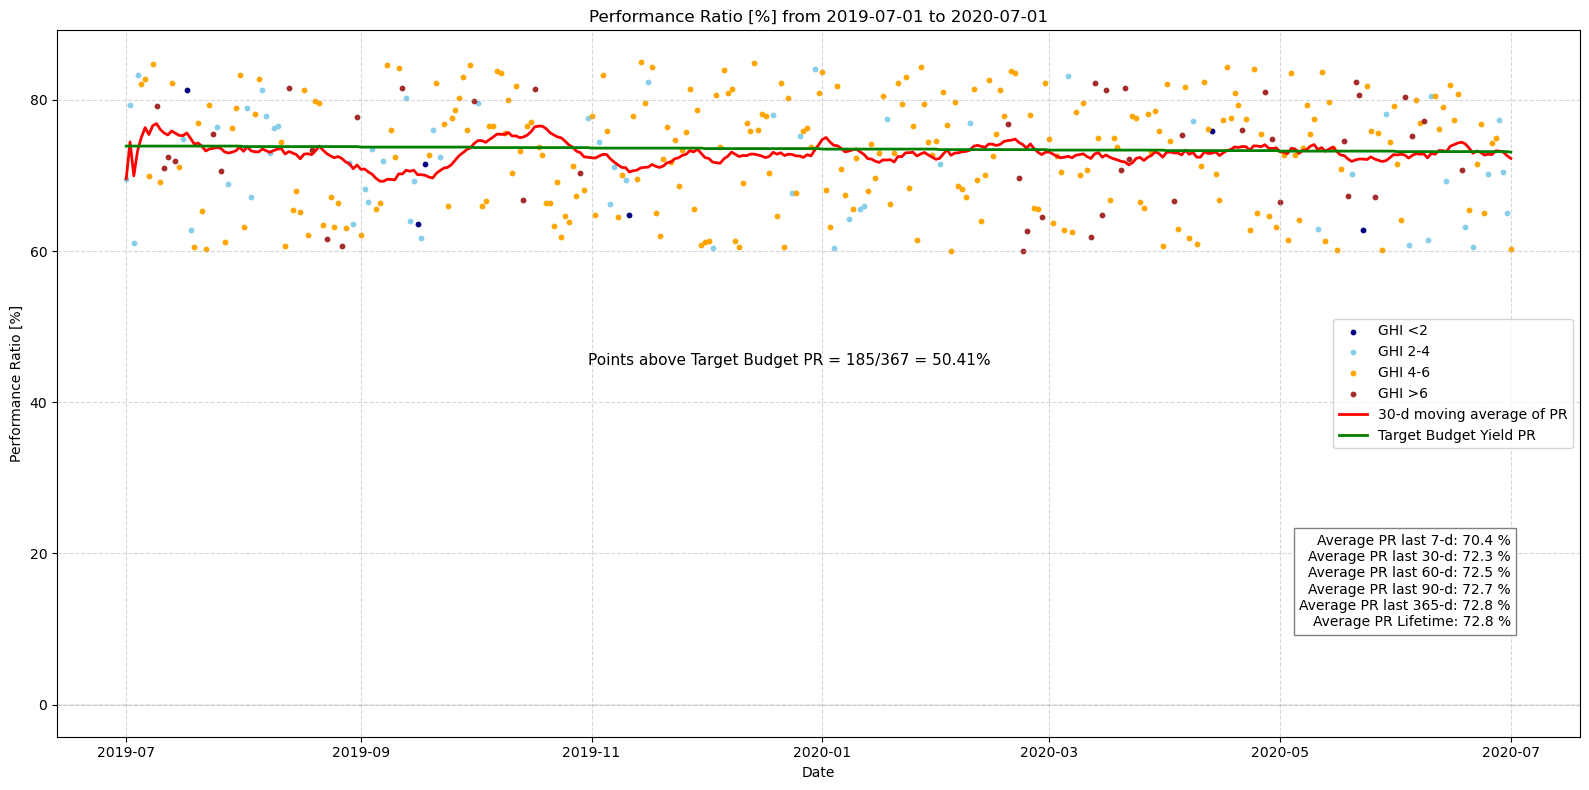

In [73]:
plot(df,'2019-03-01','2020-07-01')